In [2]:
%matplotlib inline  
## This allows figures to be plotted "inline". 
## In a normal python script, you use plt.show() to see the figures, 
## or plt.savefig("name.pdf") to save the figures 
## (you can also use this command in the notebooks)

import numpy as np  # for mathematical functions and arrays
import matplotlib.pyplot as plt  # for plot
import pandas as pd # for data analysis
## We use short names for the libraries we use a lot.

import io 
import os

import aspect_python

# Test of compaction in ASPECT -- 1D

We set a model with 30% fluid in a column, where the bottom boundary is set to 0% porosity (full solid) and the top at 100% (full liquid). 

The system compacts as the two phases segregates. 

We use the same set of equations than in Sramek, Ricard and Bercovici 2007 (SRB07), but without melting and freezing and in the limit of $\omega=0$ and $\eta_f << \eta_s$. To do that, we modify the functions for permeability, bulk viscosity and shear viscosity in the global melt model, as the resolution is based on the Keller et al. 2013. With $k_0$ a reference permeability, $\eta_i$ a reference shear viscosity for the phase $i$ ($f$ for the fluid, $s$ for the solid),  we have

- the Darcy coefficient as
$$ K_D = k(\phi) / \eta_0 = k_0 \phi^2 / \eta_f$$

- the shear viscosity as
$$ \eta = (1-\phi) \eta_s $$

- the bulk viscosity as 
$$ \xi = \frac{1-\phi}{\phi} \eta_s$$

The bulk viscosity is not defined in SRB07, but the pressure jump gives $\Delta P = -K_0 \eta_s /\phi \nabla \cdot v$, which corresponds in the McKenzie equation as $\Delta P = -\xi/(1-\phi) \nabla \cdot v$. 

## Run the model

You'll need to run the model diff_adim.prm with aspect. To do so, you need to first compile the additional library. The easiest is to use cmake: 

> cmake -D Aspect_DIR=/link/to/build/directory .

> make

Then you can run aspect: 

> ./aspect diff_adim.prm

The model is slow to run, but you can still look at preliminary results with this notebook. 

## Read the statistics file: 

We read the statistics file with two ideas: 

- Is the conservation of mass (of porosity) OK? 
- List the output files for plot later.

Number of output files so far: 1


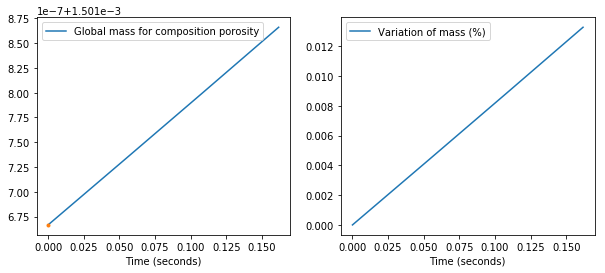

In [57]:
folder ="../"
dossier = folder+ "output-srb/"  #output folder

statistics = dossier+ "statistics"
data = aspect_python.read_statistics(statistics)


fig, ax = plt.subplots(1, 2, figsize=[10, 4])
data.plot("Time (seconds)", "Global mass for composition porosity", ax=ax[0])

# variation of mass compared to the initial value
initial_mass = data["Global mass for composition porosity"].iloc[0]
data["Variation of mass (%)"] = (data["Global mass for composition porosity"]-initial_mass)/initial_mass*100
data.plot("Time (seconds)", "Variation of mass (%)", ax=ax[1])

# We drop the lines without a visualization file. 
data = data.dropna(subset=["Visualization file name"])
# we plot the points with a visualization file on the mass evolution
ax[0].plot(data["Time (seconds)"], data["Global mass for composition porosity"],'.')


visu_files = data["Visualization file name"].values
visu_times = data["Time (seconds)"].values


print("Number of output files so far: {}".format(len(visu_files)))

## Initial time step

We can have a look at the initial time step and the profile for the velocity. 

In [58]:
file = folder+visu_files[0]+ ".0000.gnuplot" # dossier+"solution/solution-00000.0000.gnuplot"

data_0 = aspect_python.read_gnuplot_visu(file)
data_0.head()

,x,y,velocity_x,velocity_y,p_f,p_c_bar,u_f_x,u_f_y,p,T,...,density,viscosity,thermal_expansivity,nonadiabatic_temperature,strain_rate,p_c,fluid_density,permeability,fluid_viscosity,compaction_viscosity
0,0.0000,0.0000,0.000000e+00,0.000000,1.14983,0.913881,-2.771430e-12,0.000713,1.34369,0,...,2,1.0,0,0,0.029103,0.223854,1,0.00,1,1000000.00000
1,0.0025,0.0000,-3.322270e-18,0.000000,1.14983,0.913881,-2.771440e-12,0.000713,1.34369,0,...,2,1.0,0,0,0.029103,0.223854,1,0.00,1,1000000.00000
2,0.0050,0.0000,0.000000e+00,0.000000,1.14983,0.913881,-2.771430e-12,0.000713,1.34369,0,...,2,1.0,0,0,0.029103,0.223854,1,0.00,1,1000000.00000
3,0.0000,0.0025,0.000000e+00,-0.000125,1.14732,0.793170,-1.354050e-12,0.000139,1.38390,0,...,2,0.7,0,0,0.070787,0.194286,1,0.09,1,2.33333
4,0.0025,0.0025,-1.421490e-18,-0.000125,1.14732,0.793170,-1.354050e-12,0.000139,1.38390,0,...,2,0.7,0,0,0.070787,0.194286,1,0.09,1,2.33333


The analytical solution for a constant porosity and constant gravity is 

In [59]:
def analytic_Sramek_cart(phi0, y, delta):
    """ Solution analytique pour resolution Sramek in cartesian coordinates. 
    """
    h = np.sqrt(delta**2 * phi0 *
                (1. + 4. / 3. * phi0) * (1 - phi0))
    C3 = - phi0**2 * (1 - phi0) * delta**2
    C1 = C3 * (np.exp(-1 / h) - 1) / (np.exp(1 / h) - np.exp(-1 / h))
    C2 = -C1 - C3
    analytical_solution = C1 * np.exp(y / h) + C2 * np.exp(-y / h) + C3
    return analytical_solution

/home/marine/anaconda3/envs/gyic36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


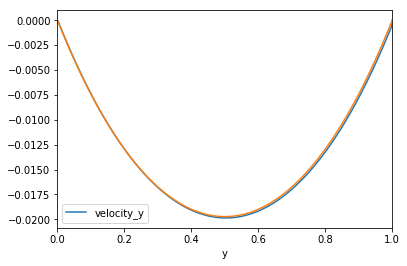

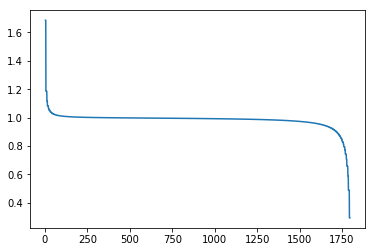

In [60]:
fig, ax = plt.subplots()
data_0.plot("y", "velocity_y", ax=ax)
#ax.set_ylim([data_0["velocity_y"].min(), 0.])
ax.set_xlim([0, data_0["y"].max()])

y = data_0["y"].values
analytical_solution = analytic_Sramek_cart(0.3, y, 1.)
ax.plot(y, analytical_solution)

fig, ax = plt.subplots()
ax.plot(analytical_solution/data_0["velocity_y"].values)

(-0.1, 0)

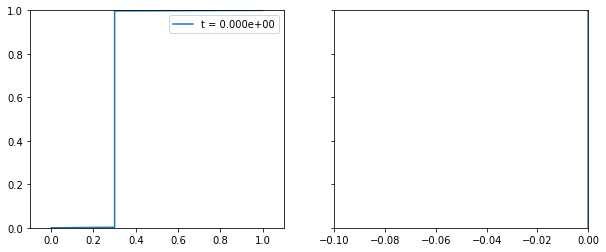

In [56]:
N=10

fig, ax = plt.subplots(1, 2, figsize=[10, 4], sharey=True)


for time, file in zip(visu_times[:--100:N], visu_files[::N]):
    #print(time, file)
    file = folder+file+".0000.gnuplot"
    df = aspect_python.read_gnuplot_visu(file)
    #df = df[df["x"]==0.5]
    ax[0].plot(df["porosity"], df["y"], label="t = {:.3e}".format(time))
    ax[1].plot(df["velocity_y"], df["y"])

ax[0].legend()
ax[0].set_xlim([-0.1, 1.1])
ax[0].set_ylim([0, 1])
ax[1].set_xlim([-0.1, 0])

### 